In [2]:
import numpy as np
import matplotlib.pyplot as plt
import importlib as imp
import osyris
from numba import njit, prange, stencil
import matplotlib.colors as colors

import disctools
import disctools.disc_cuts
import disctools.datacube
import disctools.contour_integrals
import disctools.datacube_utils
import disctools.disc_analysis
import disctools.intersections
%matplotlib notebook

In [3]:
data = osyris.Dataset(1616, path=".").load()

Processing 128 files in ./output_01616
 10% : read     171136 cells,         17 particles
 20% : read     486595 cells,        127 particles
 30% : read     679371 cells,        292 particles
 40% : read     742280 cells,        343 particles
 50% : read     796120 cells,       2147 particles
 60% : read     873537 cells,       2155 particles
 70% : read     946010 cells,      11560 particles
 80% : read    1004717 cells,      12491 particles
 90% : read    1856884 cells,      13018 particles
Loaded: 3095240 cells, 13309 particles.


In [4]:
data=osyris.extract_box(data,dx=40*osyris.units("au"), dy=40*osyris.units("au"), dz=40*osyris.units("au"), origin=data["sink"]["position"])
data["amr"]["position"]=data["amr"]["position"]-data["sink"]["position"]
imp.reload(disctools.datacube)
cube=disctools.datacube.osyris_make_cube(data)
positionArray=np.stack((data["amr"]["position"].x.values,data["amr"]["position"].y.values,data["amr"]["position"].z.values),axis=-1)
imap=disctools.datacube.make_mapping(positionArray,data["amr"]["level"].values,cube)
density=disctools.datacube.fill_array_scalar(data["hydro"]["density"].values,imap)
velocity=disctools.datacube.fill_array_vector(data["hydro"]["velocity"].x.values,data["hydro"]["velocity"].y.values,data["hydro"]["velocity"].z.values,imap)

A
B
Start mapping
alocated
building amr level 13
building amr level 14
building amr level 15
building amr level 16


In [5]:
cm_to_au = 6.6845871226706E-14
cube_au=cube*cm_to_au

In [6]:
@njit
def cut_mom_in(momentum):
    absmom=np.abs(momentum[:,:,:,2])
    return absmom>0.005*np.max(absmom)

In [7]:
peak=np.unravel_index(np.argmax(density),density.shape)
peak

(82, 81, 81)

In [8]:
angularMom=disctools.disc_analysis.angular_momentum(velocity,density,1.0,cube)
totmom=disctools.disc_analysis.angular_momentum_sphere(velocity,density,1.0,cube)
sink_pos=np.array((0.0,0.0,0.0))
sink_pos.reshape(1,3)
cut_Dens=disctools.disc_cuts.make_cut_array(density,cut_mom_in,angularMom)

<IPython.core.display.Javascript object>


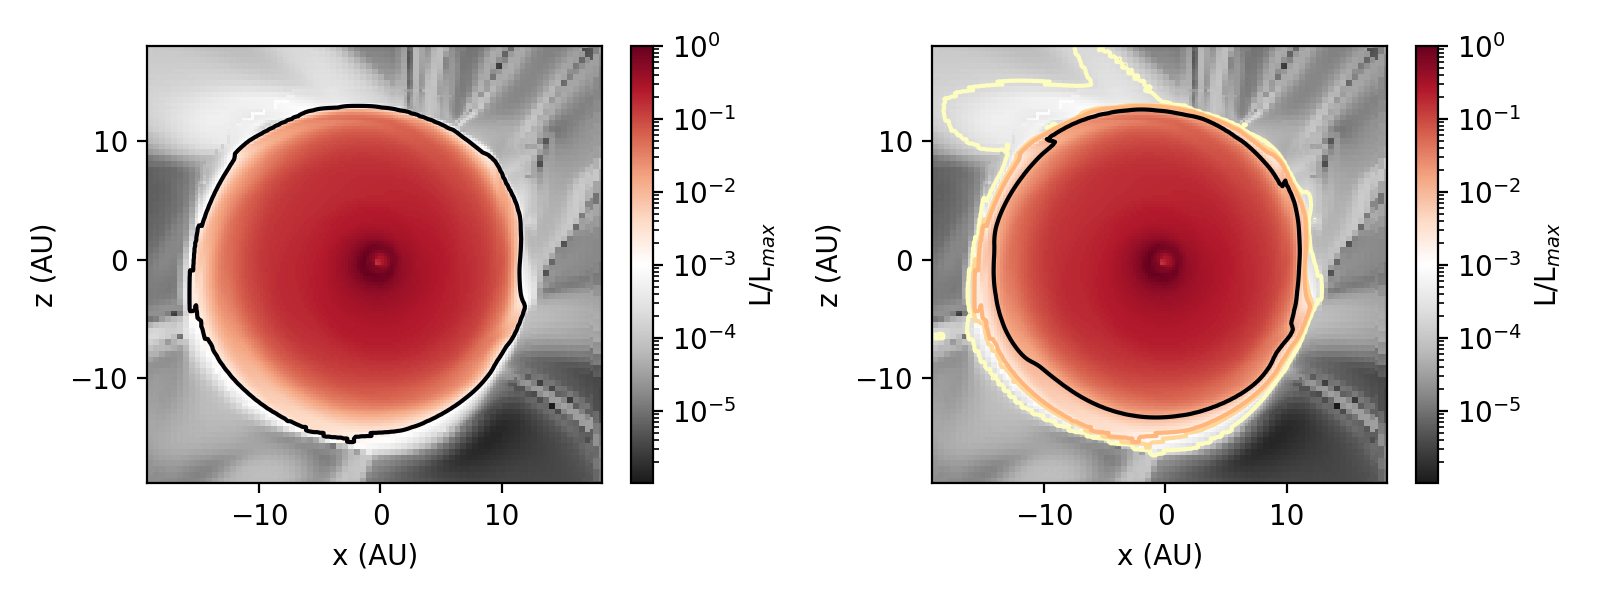

In [9]:
fig, (ax,ax1) = plt.subplots(1,2,figsize=(8,3),gridspec_kw={'width_ratios': [1, 1]})
#ecc_plot.set_figheight(10)
#map_plot.set_aspect(1)
c = ax.pcolormesh(cube_au[5:-5,5:-5,peak[2],0], cube_au[5:-5,5:-5,peak[2],1], np.linalg.norm(angularMom[5:-5,5:-5,peak[2],:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,peak[2],:],axis=-1)),norm=colors.LogNorm(), cmap='RdGy_r')
cbar=fig.colorbar(c, ax=ax).set_label("L/L$_{max}$")
cont = ax.contour(cube_au[5:-5,5:-5,peak[2],0], cube_au[5:-5,5:-5,peak[2],1], np.linalg.norm(angularMom[5:-5,5:-5,peak[2],:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,peak[2],:])), [0.0001],cmap="magma")
#cbar.clim(vmax=cut_beta.max(), vmin=1./cut_beta.max())
ax.set_xlabel("x (AU)")
ax.set_ylabel("z (AU)")

c = ax1.pcolormesh(cube_au[5:-5,5:-5,peak[2],0], cube_au[5:-5,5:-5,peak[2],1], np.linalg.norm(angularMom[5:-5,5:-5,peak[2],:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,peak[2],:],axis=-1)),norm=colors.LogNorm(), cmap='RdGy_r')
cbar=fig.colorbar(c, ax=ax1).set_label("L/L$_{max}$")
cont = ax1.contour(cube_au[5:-5,5:-5,peak[2],0], cube_au[5:-5,5:-5,peak[2],1], np.linalg.norm(angularMom[5:-5,5:-5,peak[2],:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,peak[2],:])), [0.00001,0.00006,0.0001,0.0006],cmap="magma_r")
#cbar.clim(vmax=cut_beta.max(), vmin=1./cut_beta.max())
ax1.set_xlabel("x (AU)")
ax1.set_ylabel("z (AU)")
plt.tight_layout()

In [10]:
@njit(parallel=True)
def broadcast_dot(vector_array,scalar_array):
    nx,ny,nz,_=vector_array.shape
    return_array=np.zeros_like(vector_array)
    for i in prange(nx):
        for j in range(ny):
            for k in range(nz):
                return_array[i,j,k,0]=vector_array[i,j,k,0]*scalar_array[i,j,k]
                return_array[i,j,k,1]=vector_array[i,j,k,1]*scalar_array[i,j,k]
                return_array[i,j,k,2]=vector_array[i,j,k,2]*scalar_array[i,j,k]
    return return_array

In [11]:
@njit
def get_a_on_grid_2D(star_mass,positions,velocities,dens):
    nx,ny,discard=velocities.shape
    a=np.zeros_like(dens)
    for i in prange(nx):
        for j in range(ny):
            a[i,j]=disctools.disc_analysis.get_a(star_mass,positions[i,j],velocities[i,j,:])
    return a

In [12]:
@njit
def toomre_Q(pressure,surfaceDensity):
    G=6.6743E-8
    return pressure*1.5/(np.pi*G*surfaceDensity)

@njit
def toomre_Q_array(midplanePressure,surfaceDensity):
    Q=np.zeros_like(surfaceDensity)
    nx,ny=midplanePressure.shape
    for i in prange(nx):
        for j in range(ny):
            Q[i,j]=toomre_Q(midplanePressure[i,j],surfaceDensity[i,j])
    return Q

In [13]:
@njit
def get_rad_v(velocity,position):
    nx,ny,nz,_=position.shape
    rv=np.zeros((nx,ny,nz))
    for i in prange(nx):
        for j in range(ny):
            for k in range(nz):
                rv[i,j,k]=-velocity[i,j,k,:]@position[i,j,k,:]/np.linalg.norm(position[i,j,k,:])
    return rv

@njit
def get_e_loc(L,a):
    nx,ny,nz,_=L.shape
    rv=np.zeros((nx,ny,nz))
    for i in prange(nx):
        for j in range(ny):
            for k in range(nz):
                rv[i,j,k]=np.sqrt(1.0-L[i,j,k]@L[i,j,k]/(0.264*1.989E33*a[i,j,k]))
    return rv

#ee=get_e_loc(angularMom,a_grid)

In [14]:
cut_surface=disctools.disc_cuts.get_cut_surface(disctools.disc_cuts.make_cut_array(density,cut_mom_in,angularMom))

In [15]:
@njit
def get_h(pos,L):
    nx,ny,nz,_=pos.shape
    return_array=np.zeros((nx,ny,nz))
    for i in prange(nx):
        for j in range(ny):
            for k in range(nz):
                return_array[i,j,k]=np.abs(pos[i,j,k,:]@L/np.linalg.norm(L))
    return return_array
@njit
def get_r(pos):
    nx,ny,nz,_=pos.shape
    return_array=np.zeros((nx,ny,nz))
    for i in prange(nx):
        for j in range(ny):
            for k in range(nz):
                return_array[i,j,k]=np.linalg.norm(pos[i,j,k,:])
    return return_array
h=get_h(cube,totmom)*cm_to_au
radius=get_r(cube_au)

In [16]:
rv=get_rad_v(velocity,cube)
radial_density_flux=density*rv
a_grid=disctools.disc_analysis.get_a_on_grid(0.264*1.989E33,cube_au,velocity,density)

In [17]:
surface_rdf=radial_density_flux[cut_surface]
surface_a=a_grid[cut_surface]
surface_h=h[cut_surface]
surface_r=radius[cut_surface]

<IPython.core.display.Javascript object>


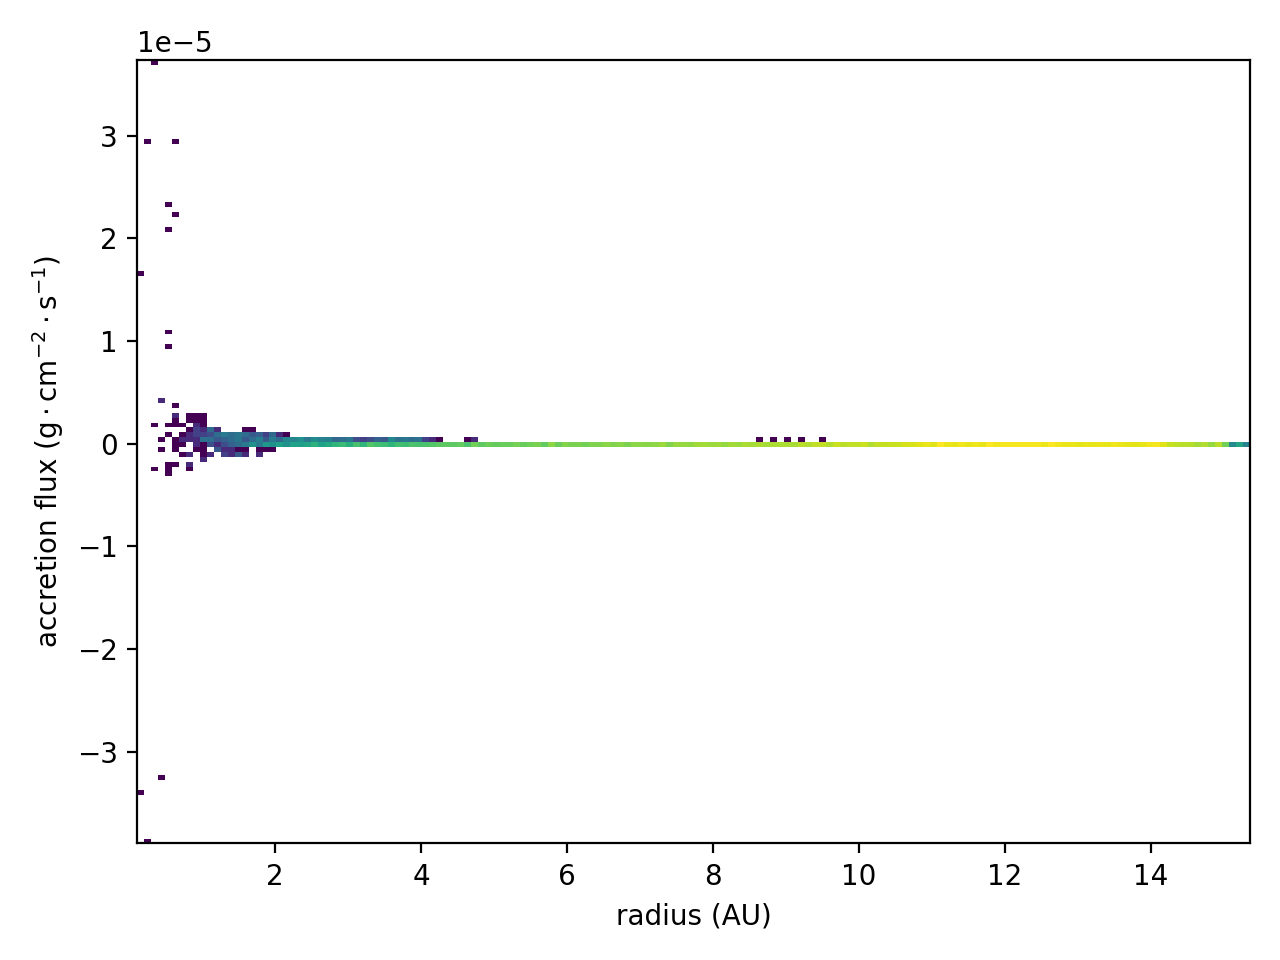

In [18]:
fig, ax = plt.subplots(tight_layout=True)
ax.hist2d(surface_r, surface_rdf, bins=160, norm=colors.LogNorm())
ax.set_xlabel("radius (AU)")
ax.set_ylabel("accretion flux ($\mathrm{g} \cdot \mathrm{cm}^{-2} \cdot \mathrm{s}^{-1}$)")
plt.show()

In [19]:
radii=np.linspace(1.0,15,30)
rv_list_midplane=[]
v_midplane=velocity[:,:,peak[2],:]
x_midplane=cube_au[:,:,peak[2],:]
dens_midplane=density[:,:,peak[2]]
a_grid=get_a_on_grid_2D(0.264*1.989E33,x_midplane,v_midplane,dens_midplane)

for a in radii:
    r_m=np.where(np.abs(surface_r-a)<0.1,True,False)
    rv=np.sum(surface_rdf[r_m])
    rv_list_midplane.append(rv*5.0)

<IPython.core.display.Javascript object>


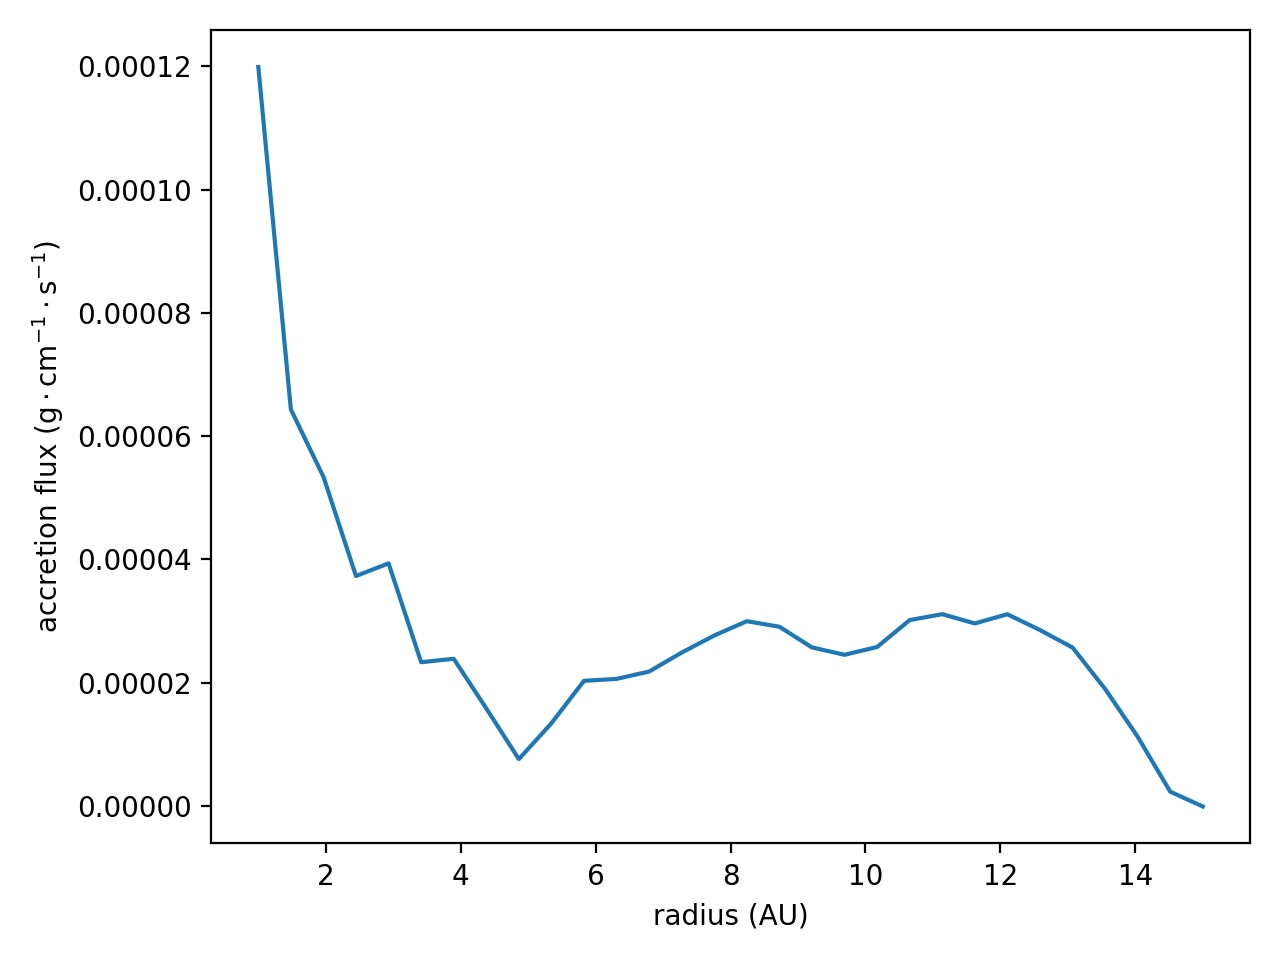

In [20]:
fig, ax = plt.subplots(tight_layout=True)
ax.plot(radii, rv_list_midplane)
ax.set_xlabel("radius (AU)")
ax.set_ylabel("accretion flux ($\mathrm{g} \cdot \mathrm{cm}^{-1} \cdot \mathrm{s}^{-1}$)")
plt.show()